In [1]:
"""
This implementation is based on the guidance from the SpinningUp article:
https://spinningup.openai.com/en/latest/algorithms/td3.html
"""

from torch import nn
import torch.nn.functional as F
import torch
import random 
import matplotlib.pyplot as plt
import numpy as np

## ----------------- Helpers ---------------- ## 

def flatten(nestedTuple: tuple):
    """
    flatten input dimensions for NNs
    """
    merged = []
    for item in nestedTuple:
        if isinstance(item, tuple) or isinstance(item, list):
            for i in item:
                merged.append(i)
        else:
            merged.append(item)  
    return merged   

## This function aims to help updating target actor/critic parameters
def targetUpdater(normalModel, targetModel, lRate = 0.3):
    for normalParam, targetParam in zip(normalModel.parameters(), targetModel.parameters()):
        targetParam.data.copy_(targetParam.data * (1.0 - lRate) + normalParam.data * lRate)
## This function aims to initilize target actor/critic parameters with normal Actor/Critc 
def initializer(normalModel, targetModel):
    for normalParam, targetParam in zip(normalModel.parameters(), targetModel.parameters()):
        targetParam.data.copy_(normalParam.data)
    
## ------------------ Actor ----------------- ## 

class Actor(nn.Module):
    """
    hidden layer can be further defined using another tuple e.g. (30, (128,64), 8) 
    or simply define in one tuple (30, 128, 64, 8)
    """
    def __init__(self, structure, use_dropout = False):
        
        super().__init__()
        
        layers = []
        ## Activation function:
        self.activation  = nn.ReLU()
        
        # Automatic population of FC network
        dim = flatten(structure)
        dim_shifted = dim[1:]
        
        for i in range(len(dim)-1):
            layers.append(nn.Linear(dim[i], dim_shifted[i]))
            
            ## Just in case for mitigating overfitting ...
            if use_dropout and i != len(dim)-2:
                layers.append(nn.Dropout(p = 0.2))
            
            if i != len(dim)-2:
                layers.append(self.activation)
        self.model = nn.Sequential(*layers)
        
    def forward(self, states):
        output = self.model(states)
        ## This is to scale back the actions to (-1, 1) for Ant environment !Need to change for other environmen
        output = torch.tanh(output)
        
        return output
    
## -------------------Critic ---------------- ## 
class Critic(nn.Module):
    """
    Critic network input dimension must equal the states_dim + actions_dim
    """
    def __init__(self, structure, use_dropout = False):
        super().__init__()
        
        layers = []
        ## Activation function:
        self.activation  = nn.ReLU()
        
        # Automatic population of FC network
        dim = flatten(structure)
        dim_shifted = dim[1:]
        
        for i in range(len(dim)-1):
            layers.append(nn.Linear(dim[i], dim_shifted[i]))
            
            ## Just in case for mitigating overfitting ...
            if use_dropout and i != len(dim)-2:
                layers.append(nn.Dropout(p = 0.2))
                
            if i != len(dim)-2:
                layers.append(self.activation)
        self.model = nn.Sequential(*layers)
        
    def forward(self, states, actions):
        
        ## concatenate states and actions, order shouldn't really matter
        inputs = torch.cat([states, actions], 1)
        output = self.model(inputs)
        return output


## -------------------Replay ---------------- ## 
class ReplayMemory():
    
    def __init__(self, size=500):
        self.size = size
        self.memory = []
        
    def addMemory(self, transition):
        """
        Transition composition:
        State, Action, Reward, `State
        """
        if self.isFull():
            ## If memory is full, remove the first stored elements
            self.memory.pop(0)
            
        self.memory.append(transition)
                
    def sample(self, batchSize):
        ## This is a very slow implementation - should be optimized if possible
        batch = random.sample(self.memory, batchSize)
        state, action, reward, stateNext, terminated = [], [], [], [], []
        for transition in batch:
            state.append(transition[0])
            action.append(transition[1])
            reward.append(transition[2])
            stateNext.append(transition[3])
            terminated.append(transition[4])
        
        return state, action, reward, stateNext, terminated
    
    def isFull(self):
        return len(self.memory)==self.size
    
    def getSize(self):
        return len(self.memory)


## ------------------- Target policy smoothing ---------------- ## 
class policySmooth:
    def __init__(self,  actionSpace, std = 0.2, clip = 0.3,):
        
        self.std = std
        self.clip = clip
        self.size = actionSpace.shape[0]
        self.high = actionSpace.high
        self.low = actionSpace.low
        
    def getAction(self, actionIn, noiseClip = True):
        noise = np.random.normal(0, self.std, self.size)
        
        ## For action no clipping, for target action apply clip
        if noiseClip:
            noise = np.clip(noise, -self.clip, self.clip)
        action = actionIn + noise
        
        return np.clip(action, self.low, self.high)


In [2]:
import torch.optim as optim

class TD3Agent:
    
    def __init__(self, actionSpace, actorStructure:tuple, criticStructure:tuple, use_dropout = False, actorLRate = 0.0003, criticLRate = 0.0003, criticLoss = 'HL', gamma = 0.9, targetUpdaterLRate = 0.3, replayMemorySize = 500, batchSize = 128, policyDelay = 2, gpu = True):
        
        self.actor = Actor(structure=actorStructure, use_dropout = use_dropout)
        self.critic1 = Critic(structure=criticStructure, use_dropout = use_dropout)
        self.critic2 = Critic(structure=criticStructure, use_dropout = use_dropout)
        
        self.targetActor = Actor(structure=actorStructure, use_dropout = use_dropout)
        self.targetCritic1 = Critic(structure=criticStructure, use_dropout = use_dropout)
        self.targetCritic2 = Critic(structure=criticStructure, use_dropout = use_dropout)
        
        self.batchSize = batchSize
        self.targetUpdaterLRate = targetUpdaterLRate
        self.gamma = gamma
        self.gpu = gpu
        self.policyDelay = policyDelay
        if self.gpu:
            self.cuda()
        
        ## initialise target models 
        initializer(self.actor, self.targetActor)
        initializer(self.critic1, self.targetCritic1)
        initializer(self.critic2, self.targetCritic2)
        
        ## initialise replay memory and random process
        self.pSmooth = policySmooth(actionSpace)
        self.rMemory = ReplayMemory(replayMemorySize)
 
        
        ## initialise optimizer
        self.actorOptim = optim.Adam(self.actor.parameters(), lr=actorLRate)
        self.criticOptim1 = optim.Adam(self.critic1.parameters(), lr=criticLRate)
        self.criticOptim2 = optim.Adam(self.critic2.parameters(), lr=criticLRate)
        
        ## initialise Loss for critic, either Huber (default) or MSE (otherwise)
        if criticLoss == 'HL':
            self.criticCriteria1 = nn.HuberLoss()
            self.criticCriteria2 = nn.HuberLoss()
        
        else:
            self.criticCriteria1 = nn.MSELoss()
            self.criticCriteria2 = nn.MSELoss()
    def updatePolicy(self, num):
        ## Assuming sufficient replay memory has been acquired
        
        ## 1. Sample (S, A, R, S`) in replay memory

        state, action, reward, stateNext, terminated = self.rMemory.sample(self.batchSize)

        if self.gpu:
            state = torch.cuda.FloatTensor(state)
            action = torch.cuda.FloatTensor(action)
            reward = torch.cuda.FloatTensor(reward)
            stateNext = torch.cuda.FloatTensor(stateNext)
            terminated = torch.cuda.FloatTensor(terminated)

        else:
            state = torch.FloatTensor(state)
            action = torch.FloatTensor(action)
            reward = torch.FloatTensor(reward)
            stateNext = torch.FloatTensor(stateNext)
            terminated = torch.FloatTensor(terminated)

        ## 2. Gradient of actor and critic  

        targetAction = self.pSmooth.getAction(self.targetActor(stateNext).detach().cpu().numpy(), noiseClip=True)
        if self.gpu:
            targetAction = torch.cuda.FloatTensor(targetAction)
        else:
            targetAction = torch.FloatTensor(targetAction)
        Q1 = self.targetCritic1(stateNext.detach(), targetAction.detach())
        Q2 = self.targetCritic2(stateNext.detach(), targetAction.detach())

        ## SMALLER Q Proceed (this verion consider actions individually)
        if Q1.mean() > Q2.mean():
            Q = Q2
        else:
            Q = Q1

        y = self.gamma * (1 - terminated) * Q + reward
        y.requires_grad_()


        yBar1 = self.critic1(state, action)
        yBar2 = self.critic2(state, action)

        criticLoss1 = self.criticCriteria1(yBar1, y)
        criticLoss2 = self.criticCriteria2(yBar2, y)

        ## backward losses
        self.criticOptim1.zero_grad()
        criticLoss1.backward(retain_graph = True)
        self.criticOptim1.step()

        self.criticOptim2.zero_grad()
        criticLoss2.backward()
        self.criticOptim2.step()

        ## update actor when delay condition is met
        if num % self.policyDelay == 0:
            actorLoss = -self.critic1(state, self.actor(state)).mean()
            self.actorOptim.zero_grad()
            actorLoss.backward()
            self.actorOptim.step()
        ## 3. Update target actor / critic
            targetUpdater(self.critic1, self.targetCritic1, self.targetUpdaterLRate)
            targetUpdater(self.critic2, self.targetCritic2, self.targetUpdaterLRate)
            targetUpdater(self.actor, self.targetActor, self.targetUpdaterLRate)


    
    ## Add option to discard noise in eval mode
    def getAction(self, states, eval = False):
        if self.gpu:
            states = torch.cuda.FloatTensor(states)
        else:
            states = torch.FloatTensor(states)
        
        action = self.actor(states).detach().cpu().numpy()
        
        # Action selection without noise clip
        if not eval:
            action = self.pSmooth.getAction(action, noiseClip=False)
            
        return action
    
    def cuda(self):
        ## Move all models to GPU
        if torch.cuda.is_available():
            self.actor.cuda()
            self.critic1.cuda()
            self.critic2.cuda()
            self.targetActor.cuda()
            self.targetCritic1.cuda()
            self.targetCritic2.cuda()
        else:
            raise ValueError("No Cuda Available")
            
    def cpu(self):
        ## Move all models back to CPU
        self.actor.cpu()
        self.critic1.cpu()
        self.critic2.cpu()
        self.targetActor.cpu()
        self.targetCritic1.cpu()
        self.targetCritic2.cpu()
        
    def evalMode(self):
        ## Evaluation mode for Agent showcase 
        self.actor.eval()
        self.critic1.eval()
        self.critic2.eval()
        self.targetActor.eval()
        self.targetCritic1.eval()  
        self.targetCritic2.eval() 
        
    def trainMode(self):
        ## Training mode for updating parameters
        self.actor.train()
        self.critic1.train()
        self.critic2.train()
        self.targetActor.train()
        self.targetCritic1.train() 
        self.targetCritic2.train() 
        
    def saveModel(self, path):
        torch.save(self.actor.state_dict(),f'{path}/actor.pkl')
        torch.save(self.targetActor.state_dict(),f'{path}/targetActor.pkl')
        
        torch.save(self.critic1.state_dict(),f'{path}/critic1.pkl')
        torch.save(self.critic2.state_dict(),f'{path}/critic2.pkl')
        
        torch.save(self.targetCritic1.state_dict(),f'{path}/targetCritic1.pkl')
        torch.save(self.targetCritic2.state_dict(),f'{path}/targetCritic2.pkl')    
        
    def loadModel(self, path):
        self.actor.load_state_dict(torch.load(f'{path}/actor.pkl'))
        self.targetActor.load_state_dict(torch.load(f'{path}/targetActor.pkl'))
        
        self.critic1.load_state_dict(torch.load(f'{path}/critic1.pkl'))
        self.critic2.load_state_dict(torch.load(f'{path}/critic2.pkl'))
        
        self.targetCritic1.load_state_dict(torch.load(f'{path}/targetCritic1.pkl'))
        self.targetCritic2.load_state_dict(torch.load(f'{path}/targetCritic2.pkl'))

In [3]:
def train(agent, env, epochs, replayMemorySize, updateStart, printEvery = 100, savePath=None):

    # ## Training Loop
    try:
        modelSaveCounter = 0
        maxR = -np.inf
        
        for e in range(epochs):
            state = env.reset()    
            episodeR = 0
            t = 0
            # Training loop for each episode
            while True:
                
                # Fill in the replay memory
                action = agent.getAction(state)
                stateNext, reward, terminated, truncated, info = env.step(action)
                agent.rMemory.addMemory((state, action, np.array([reward]), stateNext, np.array([terminated])))

                ## Update policy when memory is ready
                if agent.rMemory.getSize() > updateStart: 
                    agent.updatePolicy(t)
                    t+=1

                ## renew state and action
                state = stateNext
                episodeR += reward
       
                if terminated or truncated:
                    break
                
            rewardTracking.append(episodeR)
            rewardAvg.append(np.mean(rewardTracking[-10:]))
            
            if e > 5 and rewardTracking[-1] > maxR:
                maxR = rewardTracking[-1]
            
                ## Only save model if reward increased
                if savePath!=None:
                    agent.saveModel(savePath)
                    modelSaveCounter += 1
                
            if (e+1)%printEvery == 0:
                print(f"Episode {e+1}: reward: {episodeR}, Avg: {rewardAvg[-1]}, model improved {modelSaveCounter} times in {printEvery} episodes training.")
                modelSaveCounter = 0
                
    ## In case looping for too long
    except KeyboardInterrupt:
        return rewardTracking, rewardAvg 
    
    return rewardTracking, rewardAvg 

In [135]:
"""
This script is used as main for learning
"""
import gym
import numpy as np

## reset environment, render is not used in training
env = gym.make('Ant-v4', new_step_api = True)
env.action_space.seed(42)
state = env.reset()

## Observation and action space size
observationNum = env.observation_space.shape[0]
actionNum = env.action_space.shape[0]
totalNum = observationNum + actionNum

## Training Parameters
epochs = 200
batchSize = 128
gpu = False
rewardTracking = []
rewardAvg = []
replayMemorySize = 10000
printE = 10
path = '/home/linghao/Desktop/'
updateStart = 5000
## Initialise TD3 agent

## Some implementation suggest a single output from critic - can try
agent = TD3Agent(env.action_space,
                (observationNum, 256, 128, actionNum), 
                (totalNum, 256, 128, actionNum), 
                actorLRate = 0.0001, criticLRate = 0.0001, criticLoss = 'HL', gamma = 0.95, targetUpdaterLRate = 0.05,
                replayMemorySize = replayMemorySize, gpu=gpu, batchSize=batchSize)
agent.trainMode()
trackR, avgR = train(agent, env, epochs=epochs, replayMemorySize = replayMemorySize, updateStart = updateStart, printEvery=printE, savePath=path)
 


Episode 10: reward: -467.1536028030095, Avg: -265.1296802109524, model improved 3 times in 10 episodes training.
Episode 20: reward: -11.899758825918855, Avg: -228.22582935981978, model improved 0 times in 10 episodes training.
Episode 30: reward: 657.6354591662836, Avg: 427.17738218723025, model improved 0 times in 10 episodes training.
Episode 40: reward: 715.6723388605615, Avg: 706.8440124924736, model improved 1 times in 10 episodes training.
Episode 50: reward: 876.9561690657107, Avg: 806.8318837455339, model improved 3 times in 10 episodes training.
Episode 60: reward: 27.262726497728107, Avg: 599.8368769863971, model improved 3 times in 10 episodes training.
Episode 70: reward: 381.4449408638193, Avg: 350.38088665090737, model improved 0 times in 10 episodes training.
Episode 80: reward: 78.19873909272731, Avg: 264.6689607053269, model improved 1 times in 10 episodes training.
Episode 90: reward: 217.12691532802185, Avg: 546.8462809823006, model improved 0 times in 10 episodes t

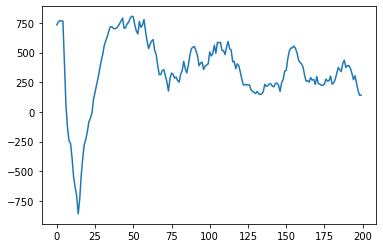

In [137]:
plt.plot(avgR)
# plt.plot(trackR)

In [16]:
# import gym
# from gym.wrappers.monitoring.video_recorder import VideoRecorder
import gym
# from gym.wrappers.monitoring.video_recorder import VideoRecorder
from torch import nn
import torch.nn.functional as F
import torch
import random 
import matplotlib.pyplot as plt
import numpy as np

## Observation and action space size
observationNum = 27
actionNum = 8
totalNum = observationNum + actionNum

## Training Parameters
epochs = 200
batchSize = 128
gpu = False
rewardTracking = []
rewardAvg = []
replayMemorySize = 10000
printE = 10
path = '/home/linghao/Desktop/'
updateStart = 5000
## Initialise TD3 agent

newEnv =  gym.make('Ant-v4', render_mode = 'human', new_step_api = True)

agentEval = TD3Agent(newEnv.action_space,
                (observationNum, 256, 128, actionNum), 
                (totalNum, 256, 128, actionNum), 
                actorLRate = 0.0001, criticLRate = 0.0001, criticLoss = 'HL', gamma = 0.95, targetUpdaterLRate = 0.05,
                replayMemorySize = replayMemorySize, gpu=gpu, batchSize=batchSize)
agentEval.loadModel('/home/linghao/Desktop/TD3_V2/')
agentEval.evalMode()


observation = newEnv.reset()

 
# video_recorder = VideoRecorder(newEnv, '/home/linghao/Desktop/Ant.mp4', enabled=True)

R = 0

for _ in range(1000):
#     video_recorder.capture_frame()
    observation, reward, terminated, truncated, info = newEnv.step(agentEval.getAction(observation, eval = True))
    
    R += reward
    
    if terminated:
        print('Term')
        break
    elif truncated:
        print('Outbound')
        break
    else:
        continue
# video_recorder.close()
# video_recorder.enabled = False

Outbound


In [17]:
newEnv.close()

In [18]:
R

1768.322015946114

In [ ]:
a